<a href="https://colab.research.google.com/github/oussezz/Master_Results/blob/main/ViT_AdditiveAttention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/sovit-123/vision_transformers.git
%cd vision_transformers

fatal: destination path 'vision_transformers' already exists and is not an empty directory.
/content/vision_transformers


In [2]:
!pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/vision_transformers
  Preparing metadata (setup.py) ... done
  Created wheel for vision-transformers: filename=vision_transformers-0.1.1.0-py3-none-any.whl size=55839 sha256=2d32e679cdf490bec9ed25482d31576ddecec14eecaf5f0029013ebd763418ee
  Stored in directory: /tmp/pip-ephem-wheel-cache-8cbhpva2/wheels/db/87/51/ad39d99a4ddd263b0b6eddc048a426338fde648f1ae338b7f0
Successfully built vision-transformers
  Attempting uninstall: vision-transformers
    Found existing installation: vision-transformers 0.1.1.0
    Uninstalling vision-transformers-0.1.1.0:
      Successfully uninstalled vision-transformers-0.1.1.0


In [3]:
%cd ..

/content


In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib
import torch.nn as nn
import torch.optim as optim
import os
import cv2
import numpy as np
import shutil

from tqdm import tqdm
from vision_transformers.models import vit

matplotlib.style.use('ggplot')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Directories.
PROJECT = 'FlameViTPretreined_lr_0.0005_3_6_2023'
RES_DIR = os.path.join('/content/drive/MyDrive/results', PROJECT)
if os.path.exists(RES_DIR):
    shutil.rmtree(RES_DIR)
os.makedirs(RES_DIR, exist_ok=True)
PLOT_DIR = os.path.join('/content/drive/MyDrive/plots', PROJECT)
os.makedirs(PLOT_DIR, exist_ok=True)
CKPT_DIR = os.path.join('/content/drive/MyDrive/checkpoints', PROJECT)
os.makedirs(CKPT_DIR, exist_ok=True)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO]: Computation device: {device}")
epochs = 5
image_size=224

[INFO]: Computation device: cuda


In [8]:
RESIZE_TO = (image_size, image_size)

train_transform = transforms.Compose(
    [transforms.Resize(RESIZE_TO),
     transforms.RandAugment(num_ops=0),
     transforms.ToTensor(),
     transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
    ])
valid_transform = transforms.Compose(
    [transforms.Resize(RESIZE_TO),
     transforms.ToTensor(),
     transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
    ])

In [9]:
import zipfile

def unzip_file(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Example usage
zip_path = '/content/drive/MyDrive/Test.zip'  # Path to the zip file
  # Path where you want to extract the files

unzip_file(zip_path,".")

import zipfile

def unzip_file(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Example usage
zip_path = '/content/drive/MyDrive/Training.zip'  # Path to the zip file
  # Path where you want to extract the files

unzip_file(zip_path,".")


In [10]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder

# Define the transforms for training and validation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to the desired size
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the image pixel values
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = ImageFolder(root, transform=transform)
        self.classes=['Fire','No_Fire']

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, label = self.dataset[index]
        return image, label

# Set the paths to your train and test folders
train_folder = 'Training'
test_folder = 'Test'

# Instantiate the custom datasets
train_dataset = CustomDataset(train_folder, transform=train_transform)
valid_dataset = CustomDataset(test_folder, transform=valid_transform)

# Set your desired batch size
batch_size = 32

# Create the data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


In [11]:
print(train_dataset.classes)

['Fire', 'No_Fire']


In [34]:
# instantiate the model
model = vit.vit_b_p16_224(
    image_size=224, pretrained=True
).to(device)
# print(model)

Loading vit_b_p16_224 pretrained weights
Loading Torchvision pretrained weights


In [35]:
model.mlp_head = nn.Linear(in_features=768, out_features=2, bias=True)
_ = model.to(device)
print(model)

ViT(
  (patches): CreatePatches(
    (patch): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-11): 12 x ModuleList(
        (0): Normalization(
          (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (fn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (out): Sequential(
              (0): Linear(in_features=768, out_features=768, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
        )
        (1): Normalization(
          (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (fn): MLP(
            (mlp_net): Sequential(
              (0): Linear(in_features=768, out_features=3072, bias=True)
              (1): GELU(approximate='none')
              (2): Dropout(p=0.0, inplace=False)
              (3): Linear(in_features=3072, out_features

In [38]:
print("=> loading checkpoint")
# loading the default weights of the ViT
checkpoint = torch.load('/content/drive/MyDrive/vitmodel_0.0005.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print("=> loaded checkpoint")

=> loading checkpoint
=> loaded checkpoint


In [24]:
import torch
import torch.nn as nn
#Define the AdditiveAttention block
class AdditiveAttention(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.embed_dim = embed_dim
        self.query = nn.Linear(embed_dim, embed_dim, bias=False)
        self.key = nn.Linear(embed_dim, embed_dim, bias=False)
        self.energy = nn.Linear(embed_dim, 1, bias=False)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        q = self.query(x)
        k = self.key(x)
        energy = self.energy(torch.tanh(q + k))
        
        attn_weights = self.softmax(energy)

        output = torch.matmul(attn_weights.transpose(-2, -1), x)
        return output

In [26]:
attention_modules = []

for layer in model.transformer.layers:
    attention_module = layer[0].fn
    attention_modules.append(attention_module)
attention_modules[0]

Attention(
  (qkv): Linear(in_features=768, out_features=2304, bias=True)
  (out): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=True)
    (1): Dropout(p=0.0, inplace=False)
  )
)

In [29]:
attention_modules_old = []
for layer in model.transformer.layers:
    attention_module = layer[0].fn
    attention_modules_old.append(attention_module)
attention_modules_old[0]

Attention(
  (qkv): Linear(in_features=768, out_features=2304, bias=True)
  (out): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=True)
    (1): Dropout(p=0.0, inplace=False)
  )
)

In [30]:
i=0
for layer in model.transformer.layers:
  pretrained_state_dict = attention_modules_old[i].state_dict()
  custom_state_dict = AdditiveAttention(embed_dim=768).state_dict()

  # Transfer the matching weights
  for key in pretrained_state_dict:
      if key in custom_state_dict:
          custom_state_dict[key] = pretrained_state_dict[key]

  # Load the updated state_dict into your custom MLPAttention
  layer[0].fn = AdditiveAttention(embed_dim=768)
  layer[0].fn.load_state_dict(custom_state_dict)
  i+=1


In [31]:
attention_modules = []

for layer in model.transformer.layers:
    attention_module = layer[0].fn
    attention_modules.append(attention_module)
attention_modules[0]

AdditiveAttention(
  (query): Linear(in_features=768, out_features=768, bias=False)
  (key): Linear(in_features=768, out_features=768, bias=False)
  (energy): Linear(in_features=768, out_features=1, bias=False)
  (softmax): Softmax(dim=-1)
)

In [32]:
model


ViT(
  (patches): CreatePatches(
    (patch): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-11): 12 x ModuleList(
        (0): Normalization(
          (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (fn): AdditiveAttention(
            (query): Linear(in_features=768, out_features=768, bias=False)
            (key): Linear(in_features=768, out_features=768, bias=False)
            (energy): Linear(in_features=768, out_features=1, bias=False)
            (softmax): Softmax(dim=-1)
          )
        )
        (1): Normalization(
          (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (fn): MLP(
            (mlp_net): Sequential(
              (0): Linear(in_features=768, out_features=3072, bias=True)
              (1): GELU(approximate='none')
              (2): Dropout(p=0.0, inplace=False)
              (3): Linear(

In [33]:
# total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"[INFO]: {total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"[INFO]: {total_trainable_params:,} trainable parameters.")

# the loss function
criterion = nn.CrossEntropyLoss()
# the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, 
                      weight_decay=0.0005)

[INFO]: 71,616,770 total parameters.
[INFO]: 71,616,770 trainable parameters.


In [15]:
# training
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1

        image, labels = data
        image = image.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()
    
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc


In [16]:
# validation
def validate(model, testloader, criterion, classes):
    model.eval()
    
    # we need two lists to keep track of class-wise accuracy
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)

            # forward pass
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
                        
            if counter == 1:
                gt_color = (0, 255, 0)
                for i in range(image.shape[0]):
                    gt_class = classes[labels[i].cpu().numpy()]
                    pred_class = classes[preds[i].cpu().numpy()]
                    if gt_class == pred_class:
                        pred_color = gt_color
                    else:
                        pred_color = (0, 0, 255)
                    img_to_write = image[i].cpu()
                    img_to_write = img_to_write / 2 + 0.5
                    img_to_write = img_to_write.numpy()
                    img_to_write = np.transpose(img_to_write, (1, 2, 0))
                    img_to_write = cv2.resize(img_to_write, (224, 224))
                    img_to_write = cv2.cvtColor(img_to_write, cv2.COLOR_RGB2BGR)
                    cv2.putText(
                        img_to_write,
                        text=f"GT: {gt_class}",
                        org=(15, 25),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=0.75,
                        color=gt_color,
                        thickness=2,
                        lineType=cv2.LINE_AA
                    )
                    cv2.putText(
                        img_to_write,
                        text=f"PRED: {pred_class}",
                        org=(15, 60),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=0.75,
                        color=pred_color,
                        thickness=2,
                        lineType=cv2.LINE_AA
                    )
                    cv2.imwrite(
                        os.path.join(RES_DIR, 'image_batch'+str(counter)+'image'+str(i)+'.jpg'), 
                        img_to_write*255.
                    )

            # calculate the accuracy for each class
            correct  = (preds == labels).squeeze()
            for i in range(len(preds)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
        
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))

    # print the accuracy for each class after evey epoch
    # the values should increase as the training goes on
    print('\n')
    for i in range(2):
        print(f"Accuracy of {classes[i]}: {100*class_correct[i]/class_total[i]}")

    return epoch_loss, epoch_acc


In [18]:
# start the training
# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")

    train_epoch_loss, train_epoch_acc = train(
        model, 
        train_dataloader,                                       
        optimizer, 
        criterion
    )
    valid_epoch_loss, valid_epoch_acc = validate(
        model, 
        valid_dataloader,  
        criterion,
        train_dataset.classes
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)

    print('\n')
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")

    print('-'*50)


[INFO]: Epoch 1 of 5
Training


100%|██████████| 1231/1231 [20:22<00:00,  1.01it/s]


Validation


100%|██████████| 270/270 [02:04<00:00,  2.16it/s]




Accuracy of Fire: 87.98909869573681
Accuracy of No_Fire: 63.189655172413794


Training loss: 0.019, training acc: 99.363
Validation loss: 0.458, validation acc: 77.974
--------------------------------------------------
[INFO]: Epoch 2 of 5
Training


100%|██████████| 1231/1231 [20:28<00:00,  1.00it/s]


Validation


100%|██████████| 270/270 [02:04<00:00,  2.17it/s]




Accuracy of Fire: 89.0013626630329
Accuracy of No_Fire: 60.747126436781606


Training loss: 0.003, training acc: 99.914
Validation loss: 0.521, validation acc: 77.591
--------------------------------------------------
[INFO]: Epoch 3 of 5
Training


100%|██████████| 1231/1231 [20:27<00:00,  1.00it/s]


Validation


100%|██████████| 270/270 [02:06<00:00,  2.14it/s]




Accuracy of Fire: 91.37628966322757
Accuracy of No_Fire: 59.367816091954026


Training loss: 0.001, training acc: 99.975
Validation loss: 0.591, validation acc: 78.450
--------------------------------------------------
[INFO]: Epoch 4 of 5
Training


100%|██████████| 1231/1231 [20:28<00:00,  1.00it/s]


Validation


100%|██████████| 270/270 [02:06<00:00,  2.13it/s]




Accuracy of Fire: 90.63655830251119
Accuracy of No_Fire: 68.87931034482759


Training loss: 0.001, training acc: 99.987
Validation loss: 0.493, validation acc: 81.850
--------------------------------------------------
[INFO]: Epoch 5 of 5
Training


100%|██████████| 1231/1231 [20:28<00:00,  1.00it/s]


Validation


100%|██████████| 270/270 [02:05<00:00,  2.15it/s]



Accuracy of Fire: 88.55363052365193
Accuracy of No_Fire: 72.41379310344827


Training loss: 0.000, training acc: 100.000
Validation loss: 0.474, validation acc: 82.036
--------------------------------------------------


In [19]:
# save the trained model to disk
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            },  os.path.join(CKPT_DIR, 'vitmodel_0.0005.pth'))

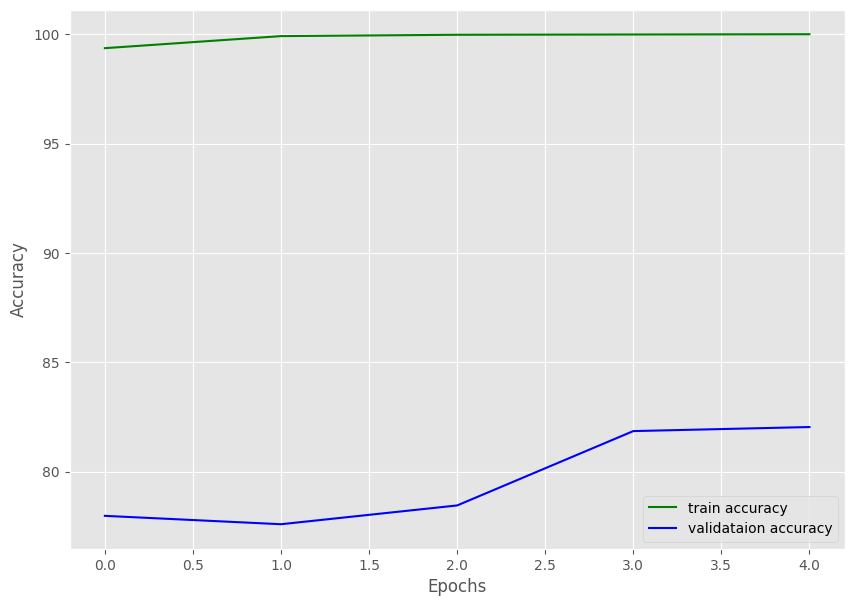

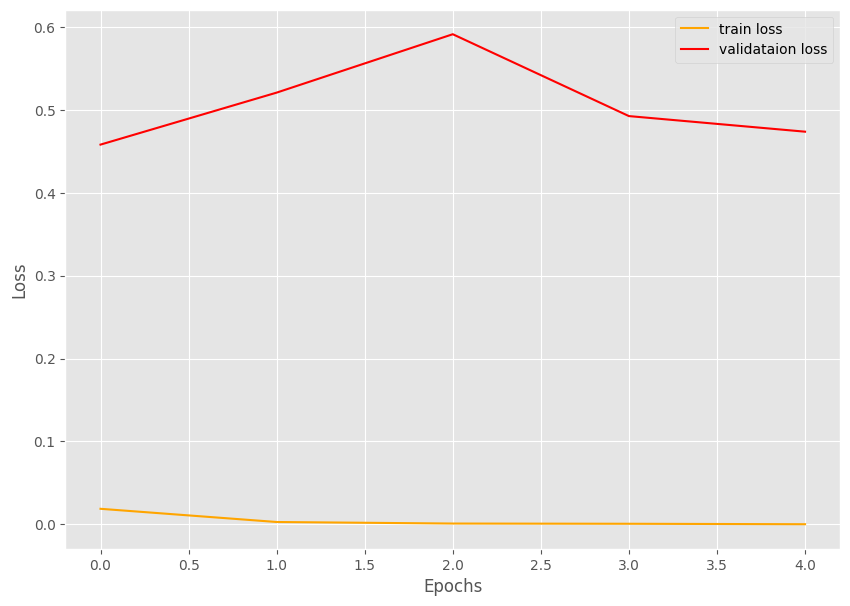

TRAINING COMPLETE


In [20]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(
    train_acc, color='green', linestyle='-', 
    label='train accuracy'
)
plt.plot(
    valid_acc, color='blue', linestyle='-', 
    label='validataion accuracy'
)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(os.path.join(PLOT_DIR, 'accuracy.png'))
plt.show()
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(
    train_loss, color='orange', linestyle='-', 
    label='train loss'
)
plt.plot(
    valid_loss, color='red', linestyle='-', 
    label='validataion loss'
)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(PLOT_DIR, 'loss.png'))
plt.show()
 
print('TRAINING COMPLETE')

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def validate(model, testloader, criterion, classes):
    model.eval()
    
    # we need two lists to keep track of class-wise accuracy
    class_correct = list(0. for i in range(2))
    class_total = list(0. for i in range(2))

    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)

            # forward pass
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
            
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())

            

            # calculate the accuracy for each class
            correct = (preds == labels).squeeze()
            for i in range(len(preds)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))

    # print the accuracy for each class after every epoch
    # the values should increase as the training goes on
    print('\n')
    for i in range(len(classes)):
        print(f"Accuracy of {classes[i]}: {100*class_correct[i]/class_total[i]}")

    # calculate the confusion matrix
    confusion_mat = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(confusion_mat)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # calculate other metrics
    report = classification_report(all_labels, all_preds, target_names=classes)
    print("\nClassification Report:")
    print(report)

    return epoch_loss, epoch_acc


Validation


100%|██████████| 270/270 [02:05<00:00,  2.16it/s]




Accuracy of Fire: 88.55363052365193
Accuracy of No_Fire: 72.41379310344827

Confusion Matrix:
[[4549  588]
 [ 960 2520]]


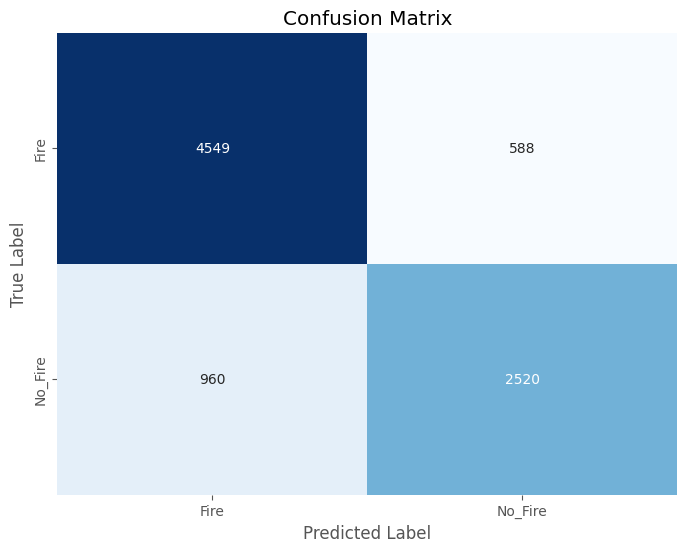


Classification Report:
              precision    recall  f1-score   support

        Fire       0.83      0.89      0.85      5137
     No_Fire       0.81      0.72      0.77      3480

    accuracy                           0.82      8617
   macro avg       0.82      0.80      0.81      8617
weighted avg       0.82      0.82      0.82      8617



In [22]:
valid_epoch_loss, valid_epoch_acc = validate(
        model, 
        valid_dataloader,  
        criterion,
        train_dataset.classes
    )